### BayBE
- https://emdgroup.github.io/baybe/examples/Searchspaces/continuous_space_botorch_function.html

In [1]:
from botorch.test_functions import Branin
from baybe import Campaign
from baybe.objectives import SingleTargetObjective
from baybe.parameters import NumericalContinuousParameter
from baybe.searchspace import SearchSpace
from baybe.targets import NumericalTarget
from baybe.utils.botorch_wrapper import botorch_function_wrapper

round = 25

In [2]:
DIMENSION = 2
TestFunctionClass = Branin

In [3]:
if not hasattr(TestFunctionClass, "dim"):
    TestFunction = TestFunctionClass(dim=DIMENSION)
elif TestFunctionClass().dim == DIMENSION:
    TestFunction = TestFunctionClass()
else:
    print(
        f"\nYou choose a dimension of {DIMENSION} for the test function"
        f"{TestFunctionClass}. However, this function can only be used in "
        f"{TestFunctionClass().dim} dimension, so the provided dimension is replaced. "
        "Also, DISC_INDICES and CONT_INDICES will be re-written."
    )
    TestFunction = TestFunctionClass()
    DIMENSION = TestFunctionClass().dim
    DISC_INDICES = list(range(0, (DIMENSION + 1) // 2))
    CONT_INDICES = list(range((DIMENSION + 1) // 2, DIMENSION))

BOUNDS = TestFunction.bounds
WRAPPED_FUNCTION = botorch_function_wrapper(test_function=TestFunction)

In [4]:
# define search space 
parameters = [
    NumericalContinuousParameter(
        name=f"x_{k+1}",
        bounds=(BOUNDS[0, k], BOUNDS[1, k]),
    )
    for k in range(DIMENSION)
]

In [5]:
# create search space
searchspace = SearchSpace.from_product(parameters=parameters)
objective = SingleTargetObjective(target=NumericalTarget(name="Target", mode="MIN"))

In [6]:
# (define optimization strategy - recommender)
# construct campaign
campaign = Campaign(searchspace=searchspace, objective=objective)

In [7]:
# recommend 1 point at a time
BATCH_SIZE = 1

for i in range(round):
    recommendation = campaign.recommend(batch_size=BATCH_SIZE)

    target_values = []
    for index, row in recommendation.iterrows():
        target_values.append(WRAPPED_FUNCTION(*row.to_list()))

    recommendation["Target"] = target_values

    campaign.add_measurements(recommendation)

c:\Users\MF\anaconda3\envs\BayBE\lib\site-packages\botorch\models\transforms\outcome.py:289: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  stdvs = Y.std(dim=-2, keepdim=True)
c:\Users\MF\anaconda3\envs\BayBE\lib\site-packages\botorch\models\utils\assorted.py:194: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1807.)
  Ymean, Ystd = torch.mean(Y, dim=-2), torch.std(Y, dim=-2)


In [8]:
campaign.measurements

,x_1,x_2,Target,BatchNr,FitNr
0,-1.451859,1.961948,54.977856,1,1.0
1,2.860707,13.676056,125.583580,2,2.0
2,2.044544,0.000000,16.417212,3,3.0
3,10.000000,0.000000,10.960894,4,4.0
4,6.514684,0.000000,20.587610,5,5.0
5,10.000000,0.000000,10.960894,6,6.0
6,10.000000,5.660874,9.007664,7,7.0
7,10.000000,3.161207,1.968184,8,8.0
8,-5.000000,0.000000,308.129059,9,9.0
9,2.507302,4.758139,6.015635,10,10.0


(0.0, 15.0)

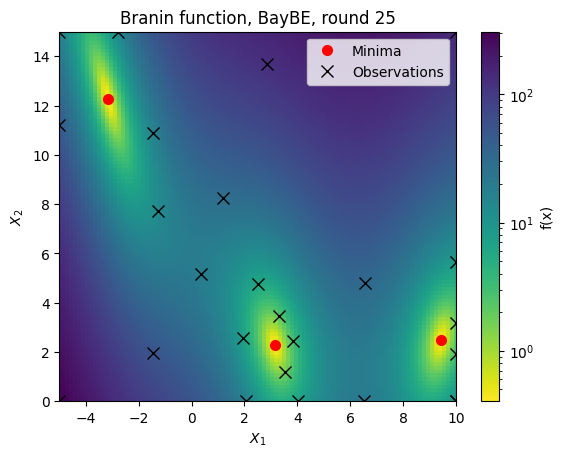

In [9]:
# plot contour plot of the branin funciton
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
fig, ax = plt.subplots()

x1_values = np.linspace(-5, 10, 100)
x2_values = np.linspace(0, 15, 100)
x_ax, y_ax = np.meshgrid(x1_values, x2_values)
vals = np.c_[x_ax.ravel(), y_ax.ravel()]
fx = np.reshape(np.array([WRAPPED_FUNCTION(x1, x2) for x1, x2 in vals]), (100, 100))

cm = ax.pcolormesh(x_ax, y_ax, fx,
                    norm=LogNorm(vmin=fx.min(),
                                vmax=fx.max()),
                    cmap='viridis_r')

minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14,
        lw=0, label="Minima")

ax.plot(campaign.measurements["x_1"], campaign.measurements["x_2"], "kx", markersize=8, label="Observations")

cb = fig.colorbar(cm)
cb.set_label("f(x)")

ax.legend(loc="best", numpoints=1)
ax.set_title(f"Branin function, BayBE, round {round}")
ax.set_xlabel("$X_1$")
ax.set_xlim([-5, 10])
ax.set_ylabel("$X_2$")
ax.set_ylim([0, 15])

In [10]:
campaign.measurements

,x_1,x_2,Target,BatchNr,FitNr
0,-1.451859,1.961948,54.977856,1,1.0
1,2.860707,13.676056,125.583580,2,2.0
2,2.044544,0.000000,16.417212,3,3.0
3,10.000000,0.000000,10.960894,4,4.0
4,6.514684,0.000000,20.587610,5,5.0
5,10.000000,0.000000,10.960894,6,6.0
6,10.000000,5.660874,9.007664,7,7.0
7,10.000000,3.161207,1.968184,8,8.0
8,-5.000000,0.000000,308.129059,9,9.0
9,2.507302,4.758139,6.015635,10,10.0


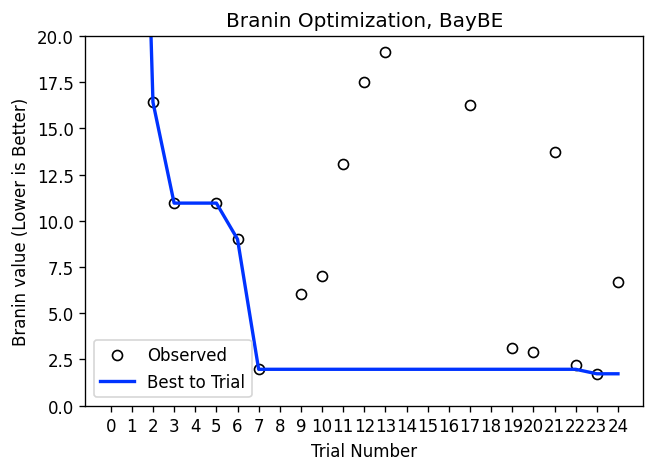

In [11]:
fig, ax = plt.subplots(figsize=(6,4), dpi=120)

ax.plot(campaign.measurements.Target, ls='None', marker='o', mfc='None', mec='k', label='Observed')

best_to_trial = np.minimum.accumulate(campaign.measurements.Target.values)
ax.plot(best_to_trial, color='#0033FF', lw=2, label='Best to Trial')

plt.xticks(range(len(campaign.measurements)))
plt.xlabel('Trial Number')
plt.ylabel('Branin value (Lower is Better)')
plt.title('Branin Optimization, BayBE')
plt.ylim(0, 20)
plt.legend()
plt.show()